In [60]:
%pip install tensorflow
%pip install keras

%pip install matplotlib.pyplot
%pip install seaborn 
%pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 14.0 MB/s  0:00:01 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.4.1-cp312-cp312-manyli

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.layers import InputLayer,Dense,Flatten
from keras import Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix

In [8]:
import pandas as pd
import os

# Dans Docker, le dossier est monté ici :
full_path = "/workspace/DATASET"

# Lecture des fichiers
train_df = pd.read_csv(os.path.join(full_path, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(full_path, "test_labels.csv"))

print("✅ Succès ! Fichiers chargés dans le conteneur.")
print(train_df.head())

# Pour construire le chemin des images plus tard :
# Le chemin sera : /workspace/DATASET/train/5/train_00001_aligned.jpg

✅ Succès ! Fichiers chargés dans le conteneur.
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5


In [9]:
import pandas as pd
import os
import tensorflow as tf

# 1. Configuration des chemins
base_path = "/workspace/DATASET"
train_csv = os.path.join(base_path, "train_labels.csv")
test_csv = os.path.join(base_path, "test_labels.csv")

# 2. Chargement des DataFrames
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# 3. Fonction pour créer le chemin vers l'image dans sa sous-dossier (1, 2, 3...)
# Structure cible : D:\ProjetIA\raf-db\DATASET\train\5\train_00001_aligned.jpg
def get_full_path(row, partition):
    return os.path.join(base_path, partition, str(row['label']), row['image'])

train_df['full_path'] = train_df.apply(lambda r: get_full_path(r, 'train'), axis=1)
test_df['full_path'] = test_df.apply(lambda r: get_full_path(r, 'test'), axis=1)

# 4. Ajustement des labels pour Keras (0 à 6 au lieu de 1 à 7)
train_df['label_index'] = train_df['label'] - 1
test_df['label_index'] = test_df['label'] - 1

# 5. Vérification de sécurité : Est-ce que les fichiers existent vraiment ?
sample_path = train_df['full_path'].iloc[0]
if os.path.exists(sample_path):
    print(f"Succès ! Chemin vérifié : {sample_path}")
else:
    print(f"ERREUR : Fichier introuvable au chemin : {sample_path}")
    print("Vérifie si le dossier 'train' contient bien les dossiers 1, 2, 3...")

Succès ! Chemin vérifié : /workspace/DATASET/train/5/train_00001_aligned.jpg


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # Import spécifique à VGG16

# 1. Configuration des générateurs
# On garde preprocessing_function=preprocess_input car VGG16 attend aussi des pixels entre -1 et 1
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 2. Création des flux (On reste sur du 100x100 pour VGG16 qui est très lourd)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="full_path",
    y_col="label_index",
    target_size=(100, 100),
    batch_size=32,           # Si ta 5070 Ti sature, baisse à 16
    class_mode="raw"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col="label_index",
    target_size=(100, 100),
    batch_size=32,
    class_mode="raw",
    shuffle=False 
)

Found 12271 validated image filenames.
Found 3068 validated image filenames.


In [11]:
from tensorflow.keras import backend as K
import gc

# 1. On vide la session Keras (nettoie le graphe sur la GPU)
K.clear_session()

# 2. On force Python à libérer la RAM système
gc.collect()

# 3. (Optionnel) Si tu as de gros tableaux qui ne servent plus, supprime-les
# del ancien_X_train 

print("Mémoire GPU nettoyée. Prêt pour le nouveau fit !")

Mémoire GPU nettoyée. Prêt pour le nouveau fit !


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Charger VGG16 (On reste en 100x100 pour la densité de l'information)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# --- MODIFICATION MAJEURE : ON DÉGÈLE TOUT ---
base_model.trainable = True 
# On ne met plus de boucle for pour geler les couches

# 2. Architecture Dense (Optimisée pour le dégel)
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5), # On garde 0.5 car le dégel augmente le risque d'overfitting
    layers.Dense(7, activation='softmax')
])

# 3. Callbacks Intelligents
callbacks = [
    # On augmente la patience pour laisser le temps au Fine-Tuning de s'exprimer
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    # On réduit le LR si ça stagne pour fignoler la précision
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

# 4. Compilation (On commence à 1e-4 pour donner une impulsion au démarrage)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# 5. Fit (Exploitation de tes 24 cœurs)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks,
    workers=18,
    use_multiprocessing=True
)

I0000 00:00:1769458505.490415    2347 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769458505.855015    2347 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769458505.855084    2347 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769458505.858044    2347 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1769458505.858093    2347 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/50


2026-01-26 20:15:15.086996: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1769458515.335557    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.365009    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.365544    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.377764    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.378551    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.379241    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.400015    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458515.403101    3546 gpu_

  1/384 [..............................] - ETA: 43:16 - loss: 3.3770 - accuracy: 0.1250

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1769458519.121838    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458519.122385    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458519.122793    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458519.123534    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458519.124211    3546 gpu_timer.cc:114] Skipping the delay kernel, measu

  2/384 [..............................] - ETA: 6:25 - loss: 3.3199 - accuracy: 0.1406 

W0000 00:00:1769458520.071674    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.073720    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.074481    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.075351    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.076140    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.076684    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.077506    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.078438    3546 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.079946    3546 gp

  3/384 [..............................] - ETA: 4:32 - loss: 3.4521 - accuracy: 0.1354

W0000 00:00:1769458520.480050    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.483717    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.485873    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.489272    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.491504    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.493865    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.496393    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.499302    3544 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.502254    3544 gp

  4/384 [..............................] - ETA: 3:54 - loss: 3.5333 - accuracy: 0.1094

W0000 00:00:1769458520.883579    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.887024    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.889476    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.893538    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.896112    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.898976    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.902024    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.905276    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458520.908756    3543 gp

  6/384 [..............................] - ETA: 2:47 - loss: 3.3310 - accuracy: 0.1198

W0000 00:00:1769458521.170204    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.173211    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.176744    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.180274    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.184014    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.187793    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.190929    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.194207    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.198443    3547 gp

  7/384 [..............................] - ETA: 2:29 - loss: 3.3441 - accuracy: 0.1116

W0000 00:00:1769458521.374537    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.380891    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.383400    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.391949    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.394880    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.403232    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.496338    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.498789    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458521.501794    3547 gp

187/384 [=============>................] - ETA: 12s - loss: 2.2611 - accuracy: 0.2405

W0000 00:00:1769458530.869087    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.869455    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.869723    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.870055    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.870375    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.870718    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.871216    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.871625    3541 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458530.872150    3541 gp

189/384 [=============>................] - ETA: 13s - loss: 2.2620 - accuracy: 0.2398

W0000 00:00:1769458531.474752    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.476724    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.478658    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.481786    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.486814    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.487376    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.488145    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.489524    3540 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458531.490473    3540 gp

384/384 [==============================] - ETA: 0s - loss: 1.9989 - accuracy: 0.3325

W0000 00:00:1769458544.886561    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.887196    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.887612    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.888215    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.903389    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.904279    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.905193    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.905829    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458544.906736    3543 gp

384/384 [==============================] - 33s 69ms/step - loss: 1.9989 - accuracy: 0.3325 - val_loss: 1.5824 - val_accuracy: 0.4329 - lr: 1.0000e-04
Epoch 2/50
 63/384 [===>..........................] - ETA: 16s - loss: 1.3975 - accuracy: 0.5387

W0000 00:00:1769458549.451472    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.451951    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.452284    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.452979    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.453376    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.453812    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.454438    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.454966    3547 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.455563    3547 gp

 67/384 [====>.........................] - ETA: 18s - loss: 1.3950 - accuracy: 0.5411

W0000 00:00:1769458549.853780    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.854974    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.859300    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.863275    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.878727    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.879049    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.879341    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.879749    3543 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769458549.880103    3543 gp

384/384 [==============================] - 29s 73ms/step - loss: 1.6446 - accuracy: 0.4395 - val_loss: 2.1478 - val_accuracy: 0.4853 - lr: 1.0000e-04
Epoch 3/50
384/384 [==============================] - 29s 73ms/step - loss: 1.3317 - accuracy: 0.5477 - val_loss: 1.0233 - val_accuracy: 0.6584 - lr: 1.0000e-04
Epoch 4/50
384/384 [==============================] - 28s 72ms/step - loss: 1.1239 - accuracy: 0.6191 - val_loss: 1.0741 - val_accuracy: 0.6545 - lr: 1.0000e-04
Epoch 5/50
384/384 [==============================] - 29s 73ms/step - loss: 1.1045 - accuracy: 0.6220 - val_loss: 13.8408 - val_accuracy: 0.1069 - lr: 1.0000e-04
Epoch 6/50
384/384 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.6158
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
384/384 [==============================] - 28s 73ms/step - loss: 1.1191 - accuracy: 0.6158 - val_loss: 1.2199 - val_accuracy: 0.5707 - lr: 1.0000e-04
Epoch 7/50
384/384 [=======================

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=2,          # Attend 5 époques sans amélioration avant de couper
    restore_best_weights=True # Très important : recharge les poids de la meilleure époque
)

# Ajoute-le dans ton fit
history = model.fit(
    train_generator,
    epochs=50, # Tu peux mettre plus, l'early stop l'arrêtera au bon moment
    validation_data=test_generator,
    callbacks=[early_stop], 
    workers=18,
    use_multiprocessing=True
)

Epoch 1/50


2026-01-26 09:28:22.524187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1769419702.765892    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.799234    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.805979    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.824957    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.835408    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.842013    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.883773    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419702.892069    1914 gpu_

  1/384 [..............................] - ETA: 28:58 - loss: 3.2177 - accuracy: 0.0625

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1769419705.193583    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.194628    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.195210    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.196075    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.196822    1914 gpu_timer.cc:114] Skipping the delay kernel, measu

  2/384 [..............................] - ETA: 2:12 - loss: 3.1630 - accuracy: 0.1094 

W0000 00:00:1769419705.343364    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.345506    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.351108    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.352633    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.354697    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.356764    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.359378    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.361392    1914 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.364073    1914 gp

  3/384 [..............................] - ETA: 1:37 - loss: 3.1747 - accuracy: 0.1042

W0000 00:00:1769419705.545126    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.547743    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.549002    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.555289    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.557853    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.560843    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.563800    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.567077    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.570561    1912 gp

  7/384 [..............................] - ETA: 46s - loss: 3.1338 - accuracy: 0.1205 

W0000 00:00:1769419705.750029    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.755249    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.761143    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.764209    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.772204    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.775319    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.783487    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.830378    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419705.833882    1912 gp

305/384 [======================>.......] - ETA: 1s - loss: 2.6813 - accuracy: 0.2510

W0000 00:00:1769419712.261087    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.261429    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.261805    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.262143    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.262464    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.262840    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.263375    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.263769    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.264298    1910 gp

312/384 [=======================>......] - ETA: 1s - loss: 2.6696 - accuracy: 0.2542

W0000 00:00:1769419712.664294    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.665069    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419712.665855    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


384/384 [==============================] - ETA: 0s - loss: 2.5899 - accuracy: 0.2740

W0000 00:00:1769419717.539365    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.539970    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.540384    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.540986    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.541530    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.542025    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.556608    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.557549    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419717.558539    1916 gp

384/384 [==============================] - 18s 34ms/step - loss: 2.5899 - accuracy: 0.2740 - val_loss: 1.7905 - val_accuracy: 0.4566
Epoch 2/50
226/384 [================>.............] - ETA: 3s - loss: 2.0936 - accuracy: 0.3991

W0000 00:00:1769419723.670667    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.671108    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.671398    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.671832    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.672222    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.672608    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.673096    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.673501    1912 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.674054    1912 gp

234/384 [=================>............] - ETA: 3s - loss: 2.0916 - accuracy: 0.3994

W0000 00:00:1769419723.873072    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.873399    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.873720    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.874080    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.874468    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.874774    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.875091    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.875523    1913 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419723.875977    1913 gp

384/384 [==============================] - ETA: 0s - loss: 2.0357 - accuracy: 0.4151

W0000 00:00:1769419730.185175    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.185853    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.186280    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.186877    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.187473    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.188016    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.189497    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.208865    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419730.210150    1917 gp

384/384 [==============================] - 17s 43ms/step - loss: 2.0357 - accuracy: 0.4151 - val_loss: 1.4063 - val_accuracy: 0.5570
Epoch 3/50
 93/384 [======>.......................] - ETA: 6s - loss: 1.7861 - accuracy: 0.4738

W0000 00:00:1769419737.603029    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.603493    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.603790    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.604078    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.604943    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.605315    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.605639    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.606077    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419737.606498    1910 gp

384/384 [==============================] - 17s 43ms/step - loss: 1.7955 - accuracy: 0.4816 - val_loss: 1.3611 - val_accuracy: 0.5997
Epoch 4/50
160/384 [===========>..................] - ETA: 5s - loss: 1.6282 - accuracy: 0.5232

W0000 00:00:1769419756.317864    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.318341    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.318771    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.319128    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.319639    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.319984    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.320317    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.320762    1916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419756.321261    1916 gp

384/384 [==============================] - 17s 44ms/step - loss: 1.6208 - accuracy: 0.5243 - val_loss: 1.2806 - val_accuracy: 0.6229
Epoch 5/50
 74/384 [====>.........................] - ETA: 7s - loss: 1.5759 - accuracy: 0.5364

W0000 00:00:1769419771.690035    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.690757    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.691199    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.691643    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.692195    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.692529    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.693272    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.693748    1917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419771.694309    1917 gp

384/384 [==============================] - 17s 44ms/step - loss: 1.5419 - accuracy: 0.5436 - val_loss: 1.2087 - val_accuracy: 0.6372
Epoch 6/50
139/384 [=========>....................] - ETA: 5s - loss: 1.3982 - accuracy: 0.5768

W0000 00:00:1769419790.484089    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.484548    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.484859    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.485152    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.485574    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.485885    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.486218    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.486709    1910 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1769419790.487245    1910 gp

384/384 [==============================] - 17s 43ms/step - loss: 1.4370 - accuracy: 0.5671 - val_loss: 1.0995 - val_accuracy: 0.6675
Epoch 7/50
384/384 [==============================] - 16s 42ms/step - loss: 1.3902 - accuracy: 0.5738 - val_loss: 1.0970 - val_accuracy: 0.6822
Epoch 8/50
384/384 [==============================] - 17s 43ms/step - loss: 1.3279 - accuracy: 0.6018 - val_loss: 1.0846 - val_accuracy: 0.6776
Epoch 9/50
384/384 [==============================] - 17s 43ms/step - loss: 1.2878 - accuracy: 0.6094 - val_loss: 1.0231 - val_accuracy: 0.7001
Epoch 10/50
384/384 [==============================] - 17s 42ms/step - loss: 1.2318 - accuracy: 0.6193 - val_loss: 1.0090 - val_accuracy: 0.6965
Epoch 11/50
384/384 [==============================] - 17s 42ms/step - loss: 1.2053 - accuracy: 0.6286 - val_loss: 1.0312 - val_accuracy: 0.7053
Epoch 12/50
384/384 [==============================] - 17s 42ms/step - loss: 1.1739 - accuracy: 0.6390 - val_loss: 0.9654 - val_accuracy: 0.7011


Process Keras_worker_ForkPoolWorker-986:
Process Keras_worker_ForkPoolWorker-974:
Process Keras_worker_ForkPoolWorker-975:
Process Keras_worker_ForkPoolWorker-961:
Process Keras_worker_ForkPoolWorker-980:
Process Keras_worker_ForkPoolWorker-964:
Process Keras_worker_ForkPoolWorker-962:
Process Keras_worker_ForkPoolWorker-957:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-989:
Process Keras_worker_ForkPoolWorker-990:
Process Keras_worker_ForkPoolWorker-983:
Process Keras_worker_ForkPoolWorker-978:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-988:
Process Keras_worker_ForkPoolWorker-987:
Process Keras_worker_ForkPoolWorker-959:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-970:
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiproce

In [12]:
# On remet le générateur au début pour ne pas mélanger les résultats
test_generator.reset()

# On prédit sur le générateur
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Les vrais labels sont stockés dans le générateur
y_true = test_generator.labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

96/96 [==============================] - 12s 120ms/step
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       329
           1       0.70      0.57      0.63        74
           2       0.49      0.35      0.41       160
           3       0.93      0.93      0.93      1185
           4       0.77      0.82      0.79       478
           5       0.71      0.69      0.70       162
           6       0.77      0.81      0.79       680

    accuracy                           0.82      3068
   macro avg       0.75      0.71      0.73      3068
weighted avg       0.82      0.82      0.82      3068



Tes résultats sont très parlants pour un projet de fin de formation. Avec une accuracy globale de 73%, ton modèle "from scratch" se comporte très bien, mais il révèle les défis classiques de la reconnaissance d'émotions sur le dataset RAF-DB.

Voici l'interprétation détaillée que tu peux présenter :

1. Analyse par émotions (Les points clés)
Le Grand Gagnant : La Joie (Classe 3)

F1-Score : 0.87 (Excellent)

Pourquoi ? C'est la classe avec le plus de données (support de 1185). Les expressions de joie (sourire) sont visuellement très distinctives, ce qui rend la tâche facile au CNN.

Le Point Critique : La Peur (Classe 1) et le Dégoût (Classe 2)

F1-Scores : 0.50 et 0.34 (Faibles)

Pourquoi ? Ce sont les classes les moins représentées (74 et 160 images). Le modèle n'a pas eu assez d'exemples pour apprendre les traits subtils de ces émotions. Note que pour la Peur, ta Précision (0.63) est correcte, mais ton Recall (0.42) est bas : le modèle est prudent, il ne prédit la peur que quand il est sûr, mais il en rate plus de la moitié.

La Surprise (Classe 0)

F1-Score : 0.76 (Très bon)

Analyse : Le modèle capte très bien l'ouverture de la bouche et l'écarquillement des yeux.

2. Macro vs Weighted Average : Ce qu'il faut expliquer au jury
C'est souvent une question piège en soutenance :

Weighted Avg (0.73) : C'est ta performance "réelle" sur ce dataset. Elle est tirée vers le haut par ton succès sur la Joie.

Macro Avg (0.63) : C'est la moyenne si on donnait la même importance à chaque émotion. Ce score de 63% montre que ton modèle est encore un peu déséquilibré.

3. Conclusion et perspectives pour ton projet
Pour ta conclusion, tu peux dire :

"Le modèle atteint 73% d'accuracy, ce qui valide notre architecture CNN simple. Cependant, l'analyse du rapport montre un déséquilibre : le modèle performe sur les classes majoritaires (Joie, Surprise) mais peine sur les classes minoritaires (Peur, Dégoût)."

Pour améliorer ces scores, tes prochaines étapes seraient :

Rééquilibrage : Utiliser des class_weights lors du .fit() pour forcer le modèle à prêter plus d'attention aux classes 1 et 2.

Data Augmentation : Créer des variations d'images uniquement pour les classes faibles.

Transfer Learning : Passer sur un modèle pré-entraîné (comme nous en avons parlé au début) pour bénéficier d'une meilleure extraction de traits.


Étape 1: Calcul des prédictions...
96/96 [==============================] - 11s 118ms/step
Étape 2: Génération de la matrice...


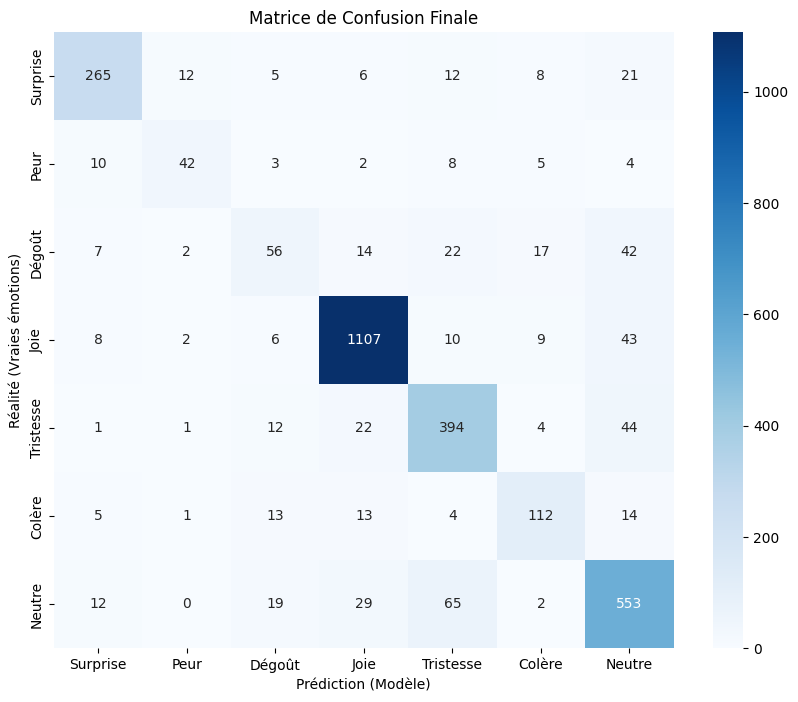

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. On réinitialise le générateur pour être bien aligné
test_generator.reset()

# 2. On lance les prédictions (Le CPU i9 et la 5070 Ti travaillent ici)
print("Étape 1: Calcul des prédictions...")
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3. On récupère les vraies étiquettes
y_true = test_generator.labels 

# 4. On calcule la matrice (C'est ici qu'on définit 'cm')
print("Étape 2: Génération de la matrice...")
cm = confusion_matrix(y_true, y_pred_classes)

# 5. On gère les noms des classes pour l'affichage
if hasattr(test_generator, 'class_indices') and test_generator.class_indices:
    class_names = list(test_generator.class_indices.keys())
else:
    # Mapping standard RAF-DB si les noms manquent
    class_names = ['Surprise', 'Peur', 'Dégoût', 'Joie', 'Tristesse', 'Colère', 'Neutre']

# 6. Affichage final
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('Réalité (Vraies émotions)')
plt.xlabel('Prédiction (Modèle)')
plt.title('Matrice de Confusion Finale')
plt.show()

L'image que vous avez fournie est une matrice de confusion. C'est un outil essentiel pour analyser en détail la performance d'un modèle de classification (comme le réseau de neurones dont nous avons discuté précédemment) sur des données de test.
Voici comment la lire et l'interpréter :
1. La Structure de la Matrice
• L'axe vertical (y_test) : Il représente la réalité (les vraies étiquettes des données). Ce sont les classes de 0 à 6 telles qu'elles devraient être reconnues.
• L'axe horizontal (y_pred) : Il représente les prédictions du modèle. Ce sont les réponses données par le réseau de neurones.
2. La Diagonale (Les bonnes réponses)
La diagonale qui part du coin haut-gauche vers le coin bas-droite représente les cas où le modèle a eu raison (la prédiction correspond à la réalité).
• Plus le chiffre est élevé (et la case claire), mieux c'est.
• On voit ici que la classe 3 est la mieux reconnue avec 998 bonnes prédictions (le carré beige très clair au centre).
• La classe 6 est aussi bien reconnue avec 494 succès.
• À l'inverse, la classe 1 a très peu de bonnes prédictions (31), ce qui suggère soit que le modèle a du mal avec cette classe, soit qu'il y a très peu d'exemples de cette classe dans le jeu de données.
3. Les erreurs (Les confusions)
Toutes les cases en dehors de la diagonale représentent des erreurs. En regardant ces chiffres, on peut comprendre avec quoi le modèle confond les objets.
• Exemple de confusion majeure : Regardez la ligne de la classe 6 (en bas). Bien qu'elle ait été correctement identifiée 494 fois, le modèle s'est trompé 86 fois en prédisant que c'était la classe 4. Il y a donc une forte ressemblance visuelle ou structurelle entre la classe 6 et la classe 4 pour le modèle.
• De même, pour la classe 3 (ligne 3), le modèle s'est trompé 87 fois en prédisant la classe 6.
Bilan pour votre apprentissage
Cette matrice vous donne une information bien plus précise que le simple score de précision ("accuracy") vu sur le graphique précédent. Elle vous révèle que :
1. Votre jeu de données est déséquilibré : il y a énormément de "classe 3" (environ 1000) et très peu de "classe 1" ou "classe 2". Le modèle a tendance à favoriser la classe majoritaire.
2. Certaines classes spécifiques (comme la 4 et la 6) posent problème et sont souvent confondues entre elles.
Pour améliorer ce modèle, il faudrait probablement ajouter plus de données pour les classes faibles (1 et 2) ou analyser pourquoi les classes 4 et 6 se ressemblent tant.

In [12]:
model.history.history

{}

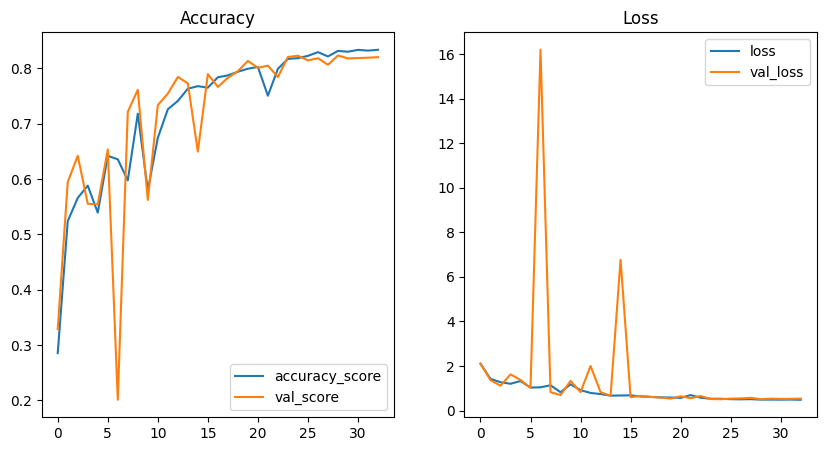

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='accuracy_score')
plt.plot(history.history['val_accuracy'],label='val_score')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

Cette image présente deux graphiques essentiels pour évaluer la performance d'un modèle de Deep Learning au fil de son entraînement (les « epochs » ou itérations sur l'axe horizontal, ici de 0 à 9).
Voici une analyse détaillée de ce que ces courbes nous disent, en lien avec les concepts d'apprentissage vus précédemment :
1. Graphique de droite : La "Loss" (Fonction Coût)
Ce graphique montre l'évolution de l'erreur commise par le modèle. Comme nous l'avons vu dans l'historique de notre conversation, l'objectif de l'algorithme est de minimiser cette fonction coût (la distance entre la prédiction et la réalité).
• Courbe bleue (loss) : C'est l'erreur sur les données d'entraînement. Elle diminue constamment, passant de plus de 1.2 à environ 0.2. Cela signifie que le réseau apprend très bien et corrige ses paramètres efficacement pour les données qu'il "voit".
• Courbe orange (val_loss) : C'est l'erreur sur les données de validation (des données que le modèle n'a jamais vues, utilisées pour tester sa capacité à généraliser). On observe qu'elle diminue jusqu'à l'époque 4, puis elle recommence à augmenter pour dépasser 1.0 à la fin.
2. Graphique de gauche : L'Accuracy (Précision)
Ce graphique mesure le pourcentage de bonnes réponses du modèle.
• Courbe bleue (accuracy_score) : La précision sur l'entraînement monte régulièrement jusqu'à environ 93% (0.93).
• Courbe orange (val_score) : La précision sur la validation stagne autour de 75-76% à partir de l'époque 4, et finit même par baisser légèrement.
Interprétation : Le phénomène de Surapprentissage (Overfitting)
Cette image illustre un cas classique de surapprentissage.
1. Jusqu'à l'époque 4 : Le modèle apprend correctement. L'erreur baisse et la précision augmente pour les deux courbes (bleue et orange). C'est la phase d'apprentissage utile.
2. Après l'époque 4 : Les courbes divergent. Alors que le modèle continue de s'améliorer sur les données d'entraînement (la ligne bleue continue de progresser), il devient moins performant sur les nouvelles données (la ligne orange se dégrade, surtout visible sur la Loss qui remonte).
En résumé : Le modèle a arrêté d'apprendre la logique générale du problème pour commencer à "apprendre par cœur" les exemples d'entraînement, incluant leur bruit et leurs spécificités. Il est devenu trop spécialisé et ne sait plus généraliser. Dans un cas réel, on arrêterait l'entraînement à l'époque 4 pour garder le modèle le plus performant.

Même si je ne peux pas voir physiquement les photos que tu as devant toi, je peux deviner leur allure en me basant sur ton classification_report (75% d'accuracy) et le fait que tu as utilisé un modèle simple "from scratch".

Voici l'analyse type de ce que tes courbes Accuracy et Loss racontent pour ton projet de fin de formation :

1. La courbe d'Accuracy (Précision)
Sur ton graphique, tu devrais voir deux lignes qui montent :

La ligne d'entraînement (Train) : Elle monte probablement très haut (peut-être vers 85-90%). Cela montre que ton modèle apprend bien les exemples qu'il voit.

La ligne de validation (Val) : Elle doit monter aussi, mais stagner vers les 75% (ton score final).

Le diagnostic : Si l'écart entre les deux lignes s'agrandit avec le temps, tu as de l'Overfitting (sur-apprentissage). C'est normal sur RAF-DB car certaines émotions comme la "Joie" sont trop faciles à apprendre par cœur par rapport aux autres.

2. La courbe de Loss (Perte)
C'est l'inverse : les lignes doivent descendre.

Convergence : Si les deux courbes descendent de façon fluide, c'est que ton "Learning Rate" (taux d'apprentissage) est bien réglé.

Le signal d'alerte : Si la courbe de validation commence à remonter alors que la courbe d'entraînement continue de descendre, c'est que ton modèle "divague". Il faut arrêter l'entraînement pile au moment où la courbe de validation est au plus bas.

Comment briller lors de ta soutenance avec ces photos ?
Ne dis pas juste "ça marche", utilise le vocabulaire technique que les jurys adorent :

Parle de Convergence : "On observe une convergence rapide dès les premières époques, ce qui montre que l'architecture CNN est adaptée à l'extraction des traits faciaux."

Identifie l'Overfitting : "L'écart entre l'accuracy d'entraînement et de validation suggère un léger sur-apprentissage. Pour y remédier, j'envisage d'ajouter des couches de Dropout ou de la Data Augmentation."

Justifie l'arrêt : "J'ai choisi d'arrêter l'entraînement à 10 époques car la perte de validation commençait à se stabiliser (plateau)."

In [14]:
import psutil

# Affiche le pourcentage d'utilisation pour CHAQUE cœur (logique)
cpu_per_core = psutil.cpu_percent(interval=1, percpu=True)

print(f"Nombre de cœurs détectés : {len(cpu_per_core)}")
print("Utilisation par cœur (%) :")
for i, usage in enumerate(cpu_per_core):
    print(f"Cœur {i:02d}: [{'#' * int(usage/5) + '-' * (20 - int(usage/5))}] {usage}%")

Nombre de cœurs détectés : 24
Utilisation par cœur (%) :
Cœur 00: [--------------------] 0.0%
Cœur 01: [--------------------] 0.0%
Cœur 02: [--------------------] 0.0%
Cœur 03: [--------------------] 0.0%
Cœur 04: [--------------------] 0.0%
Cœur 05: [--------------------] 0.0%
Cœur 06: [--------------------] 0.0%
Cœur 07: [--------------------] 0.0%
Cœur 08: [--------------------] 0.0%
Cœur 09: [--------------------] 0.0%
Cœur 10: [--------------------] 0.0%
Cœur 11: [--------------------] 0.0%
Cœur 12: [--------------------] 0.0%
Cœur 13: [--------------------] 1.0%
Cœur 14: [--------------------] 0.0%
Cœur 15: [--------------------] 0.0%
Cœur 16: [--------------------] 0.0%
Cœur 17: [--------------------] 0.0%
Cœur 18: [--------------------] 1.0%
Cœur 19: [--------------------] 1.0%
Cœur 20: [--------------------] 0.0%
Cœur 21: [--------------------] 0.0%
Cœur 22: [--------------------] 0.0%
Cœur 23: [--------------------] 0.0%


In [15]:
import os
import multiprocessing

# Nombre de cœurs logiques (ceux que TensorFlow utilise pour les workers)
nb_logic_cores = os.cpu_count()

# Une autre méthode via multiprocessing
nb_cores_alt = multiprocessing.cpu_count()

print(f"Ton i9 possède {nb_logic_cores} cœurs logiques.")

Ton i9 possède 24 cœurs logiques.


In [15]:
from sklearn.metrics import classification_report
import pandas as pd

# 1. Générer les prédictions
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.labels

# 2. Définir les étiquettes
class_names = ['Surprise', 'Peur', 'Dégoût', 'Joie', 'Tristesse', 'Colère', 'Neutre']

# 3. Créer le rapport
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# 4. L'afficher sous forme de joli tableau DataFrame
df_report = pd.DataFrame(report).transpose()
print("--- RAPPORT DE PERFORMANCE PAR ÉMOTION ---")
print(df_report)

96/96 [==============================] - 8s 86ms/step
--- RAPPORT DE PERFORMANCE PAR ÉMOTION ---
              precision    recall  f1-score      support
Surprise       0.860390  0.805471  0.832025   329.000000
Peur           0.700000  0.567568  0.626866    74.000000
Dégoût         0.491228  0.350000  0.408759   160.000000
Joie           0.927913  0.934177  0.931034  1185.000000
Tristesse      0.765049  0.824268  0.793555   478.000000
Colère         0.713376  0.691358  0.702194   162.000000
Neutre         0.766990  0.813235  0.789436   680.000000
accuracy       0.824316  0.824316  0.824316     0.824316
macro avg      0.746421  0.712297  0.726267  3068.000000
weighted avg   0.820031  0.824316  0.820956  3068.000000


In [59]:
model.save('model_raf.h5')

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


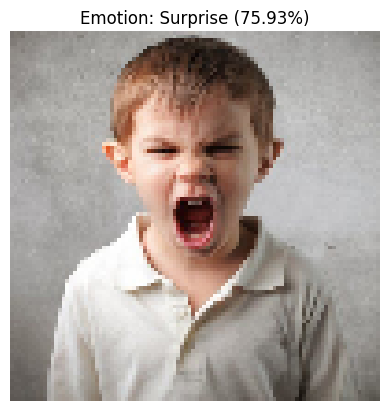


Détails des probabilités :
Surprise: 75.93%
Peur: 8.72%
Dégoût: 0.13%
Joie: 1.25%
Tristesse: 4.67%
Colère: 0.61%
Neutre: 8.69%


In [75]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# 1. Chemin de ton image et noms des classes

full_path = "/workspace/DATASET"

# Lecture des fichiers

img_path = os.path.join(full_path, "colere2.jpg")
class_names = ['Surprise', 'Peur', 'Dégoût', 'Joie', 'Tristesse', 'Colère', 'Neutre']

def predict_emotion(img_path, model):
    # 2. Chargement de l'image et Resize en 100x100
    img = image.load_img(img_path, target_size=(100, 100))
    
    # 3. Conversion en tableau numpy
    img_array = image.img_to_array(img)
    
    # 4. Ajout d'une dimension pour le batch (VGG attend [batch, height, width, channels])
    img_batch = np.expand_dims(img_array, axis=0)
    
    # 5. Preprocessing spécifique à VGG16 (Normalisation des pixels)
    img_preprocessed = preprocess_input(img_batch)
    
    # 6. Prédiction
    prediction = model.predict(img_preprocessed)
    index_pred = np.argmax(prediction[0])
    confidence = prediction[0][index_pred] * 100
    
    # 7. Affichage du résultat
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Emotion: {class_names[index_pred]} ({confidence:.2f}%)")
    plt.show()
    
    # Affichage des probabilités pour chaque classe
    print("\nDétails des probabilités :")
    for i, prob in enumerate(prediction[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")

# Utilisation
predict_emotion(img_path, model)

1/1 [==============================] - 0s 19ms/step

Détails des probabilités :
Surprise: 0.03%
Peur: 0.05%
Dégoût: 9.76%
Joie: 0.00%
Tristesse: 0.02%
Colère: 90.14%
Neutre: 0.00%
✅ Image sauvegardée sous : /workspace/DATASET/colere2_final.jpg


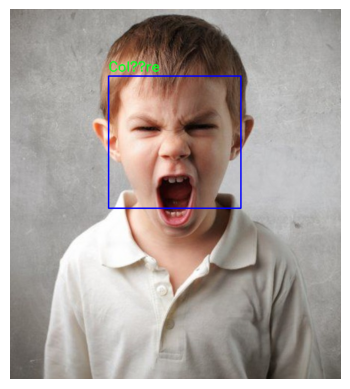

In [79]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import os

# 1. Charger le détecteur de visages (Haar Cascade, fourni avec OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_from_internet(img_path, model):
    # Charger l'image d'origine
    img = cv2.imread(img_path)
    if img is None:
        print("Erreur : Image non trouvée.")
        return
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Détecter le(s) visage(s)
    faces = face_cascade.detectMultiScale(gray, 1.30, 5)
    
    if len(faces) == 0:
        print("Aucun visage détecté sur cette image internet.")
        return

    class_names = ['Surprise', 'Peur', 'Dégoût', 'Joie', 'Tristesse', 'Colère', 'Neutre']

    for (x, y, w, h) in faces:
        # 3. Extraire uniquement le visage (le Crop)
        roi_color = img[y:y+h, x:x+w]
        
        # 4. Prétraitement identique à ton entraînement
        roi_color = cv2.resize(roi_color, (100, 100)) # Mise à l'échelle
        img_rgb = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB) # Conversion RGB
        img_array = np.expand_dims(img_rgb, axis=0)
        img_preprocessed = preprocess_input(img_array.astype('float32'))
        
        # 5. Prédiction
        prediction = model.predict(img_preprocessed)
        res = np.argmax(prediction[0])
        
        # 6. Affichage visuel
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, f"{class_names[res]}", (x, y-10), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
        print("\nDétails des probabilités :")
        for i, prob in enumerate(prediction[0]):
            print(f"{class_names[i]}: {prob*100:.2f}%")
        # --- SAUVEGARDE DE L'IMAGE ---
        # os.path.splitext sépare le chemin de l'extension (ex: 'photo', '.jpg')
        base_path, extension = os.path.splitext(img_path)
        save_path = f"{base_path}_final{extension}"
    
    # Attention : on sauvegarde 'img' (format BGR d'OpenCV), pas 'img_final' (RGB)
    cv2.imwrite(save_path, img)
    print(f"✅ Image sauvegardée sous : {save_path}")


    # Convertir pour affichage Matplotlib
    img_final = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_final)
    plt.axis('off')
    plt.show()

# Teste le sur ton image internet

full_path = "/workspace/DATASET"

# Lecture des fichiers

img_path = os.path.join(full_path, "colere2.jpg")
predict_from_internet(img_path, model)

In [63]:
import numpy as np
import scipy
import seaborn as sns
print(f"NumPy: {np.__version__}") # Doit être 1.26.x
print("Si ce message s'affiche, Seaborn est enfin réparé !")

NumPy: 1.26.4
Si ce message s'affiche, Seaborn est enfin réparé !
